# Code for analyzing receptor subunits

In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib_venn import venn2, venn2_circles
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import decoupler as dc
rcParams["font.family"] = "Ubuntu Mono"

In [2]:
from pathlib import Path
import os

In [3]:
root_dir = "/tscc/projects/ps-epigen/users/biy022/biccn/data/SNAREdata/scenicplus/L2_3_IT/"
os.chdir(root_dir)
figure_dir = Path("/tscc/projects/ps-epigen/users/biy022/biccn/analysis/final_figures/receptor_subunits/")

In [4]:
direct_table = pd.read_csv("scplus_outputs/eRegulon_direct.tsv", sep="\t", header=0)
extend_table = pd.read_csv("scplus_outputs/eRegulons_extended.tsv", sep="\t", header=0)
regulons_table = pd.concat([direct_table, extend_table], axis=0)
regulons_table.reset_index(drop=True, inplace=True)
regulons_table = regulons_table[regulons_table["eRegulon_name"].str.endswith("+/+")].copy()

In [5]:
ST_positive_peak_table = pd.read_csv(
    "corr_regions_ST_5e-1_5e-2_expr_filtered/L2_3_IT_positive.tsv",
    sep="\t", header=None
)
ST_positive_peak_table.columns = ["Region"]
ST_negative_peak_table = pd.read_csv(
    "corr_regions_ST_5e-1_5e-2_expr_filtered/L2_3_IT_negative.tsv",
    sep="\t", header=None
)
ST_negative_peak_table.columns = ["Region"]
ST_positive_peak_table["Region"] = ST_positive_peak_table.apply(
    lambda x: ":".join(x["Region"].split("-", 1)), axis=1)
ST_negative_peak_table["Region"] = ST_negative_peak_table.apply(
    lambda x: ":".join(x["Region"].split("-", 1)), axis=1)

In [6]:
gene_corr_table = pd.read_csv(
    "../other_celltypes/corr_genes_ST_7e-1_1e-2_expr_filtered/L2_3_IT_RC_table.tsv",
    header=0, sep="\t"
)

In [7]:
all_positive_edges = pd.merge(regulons_table, ST_positive_peak_table, on="Region", how="inner")
all_negative_edges = pd.merge(regulons_table, ST_negative_peak_table, on="Region", how="inner")

## Homer based

In [8]:
gene_corr_table["group1"] = "null"
gene_corr_table_null = gene_corr_table.copy()
gene_corr_table.loc[gene_corr_table["gene"].isin(set(all_positive_edges["Gene"])), "group1"] = "positive_enhancer"
gene_corr_table_pos = gene_corr_table[gene_corr_table["group1"].isin(["positive_enhancer"])].copy()
gene_corr_table.loc[gene_corr_table["gene"].isin(set(all_negative_edges["Gene"])), "group1"] = "negative_enhancer"
gene_corr_table_neg = gene_corr_table[gene_corr_table["group1"].isin(["negative_enhancer"])].copy()
plot_table = pd.concat([gene_corr_table_null, gene_corr_table_pos, gene_corr_table_neg])
del gene_corr_table["group1"]

In [9]:
from scipy.stats import mannwhitneyu
group_null = plot_table[plot_table["group1"] == "null"]["corr"]
group_pos = plot_table[plot_table["group1"] == "positive_enhancer"]["corr"]
group_neg = plot_table[plot_table["group1"] == "negative_enhancer"]["corr"]

stat_pos, p_pos = mannwhitneyu(group_pos, group_null)
print(f"Rank-sum test result for positive enhancers: stats: {stat_pos}, p value: {p_pos}")
stat_neg, p_neg = mannwhitneyu(group_null, group_neg)
print(f"Rank-sum test result for negative enhancers: stats: {stat_neg}, p value: {p_neg}")

Rank-sum test result for positive enhancers: stats: 13842181.5, p value: 1.2124567570674645e-156
Rank-sum test result for negative enhancers: stats: 47719887.0, p value: 2.5169270323502194e-189


null                 27730
negative_enhancer     2548
positive_enhancer      613
Name: group1, dtype: int64


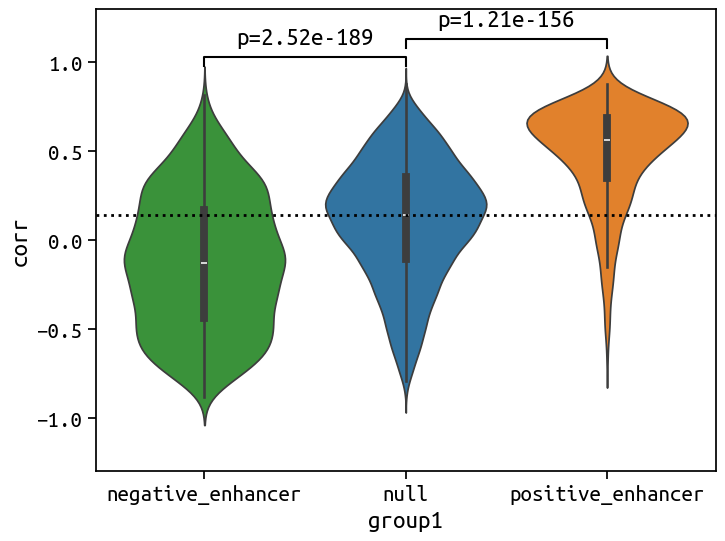

In [10]:
sns.set_context("notebook", font_scale=1.5)
print(plot_table["group1"].value_counts())
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(8)
fig.set_figheight(6)
sns.violinplot(
    plot_table, x="group1", y="corr", hue="group1", 
    order=["negative_enhancer", "null", "positive_enhancer"], ax=ax
)
null_median = np.median(group_null)
ax.axhline(null_median, color="black", linestyle="dotted", linewidth=2)
ax.set_ylim(-1.3, 1.3)
def add_bracket(x1, x2, y, pvalue, h, ax):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, color="black")
    ax.text((x1+x2)/2, y+2*h, f"p={pvalue:.2e}", ha="center", va="bottom")
bracket_base = np.max(plot_table["corr"])
add_bracket(0, 1, bracket_base+0.1, p_neg, 0.05, ax)
add_bracket(1, 2, bracket_base+0.2, p_pos, 0.05, ax)
fig.savefig(figure_dir / "enhancers_target_RNA_corr.pdf", dpi=300, format="pdf")

In [11]:
gene_corr_table["group1"] = "null"
gene_corr_table_null = gene_corr_table[gene_corr_table["gene"].isin(set(regulons_table["Gene"]))].copy()
gene_corr_table.loc[gene_corr_table["gene"].isin(set(all_positive_edges["Gene"])), "group1"] = "positive_enhancer"
gene_corr_table_pos = gene_corr_table[gene_corr_table["group1"].isin(["positive_enhancer"])].copy()
gene_corr_table.loc[gene_corr_table["gene"].isin(set(all_negative_edges["Gene"])), "group1"] = "negative_enhancer"
gene_corr_table_neg = gene_corr_table[gene_corr_table["group1"].isin(["negative_enhancer"])].copy()
plot_table = pd.concat([gene_corr_table_null, gene_corr_table_pos, gene_corr_table_neg])
del gene_corr_table["group1"]

In [12]:
from scipy.stats import mannwhitneyu
group_null = plot_table[plot_table["group1"] == "null"]["corr"]
group_pos = plot_table[plot_table["group1"] == "positive_enhancer"]["corr"]
group_neg = plot_table[plot_table["group1"] == "negative_enhancer"]["corr"]

stat_pos, p_pos = mannwhitneyu(group_pos, group_null)
print(f"Rank-sum test result for positive enhancers: stats: {stat_pos}, p value: {p_pos}")
stat_neg, p_neg = mannwhitneyu(group_null, group_neg)
print(f"Rank-sum test result for negative enhancers: stats: {stat_neg}, p value: {p_neg}")

Rank-sum test result for positive enhancers: stats: 4015803.5, p value: 3.6393879766247493e-135
Rank-sum test result for negative enhancers: stats: 13689892.0, p value: 1.7773913929249586e-124


null                 8198
negative_enhancer    2548
positive_enhancer     613
Name: group1, dtype: int64


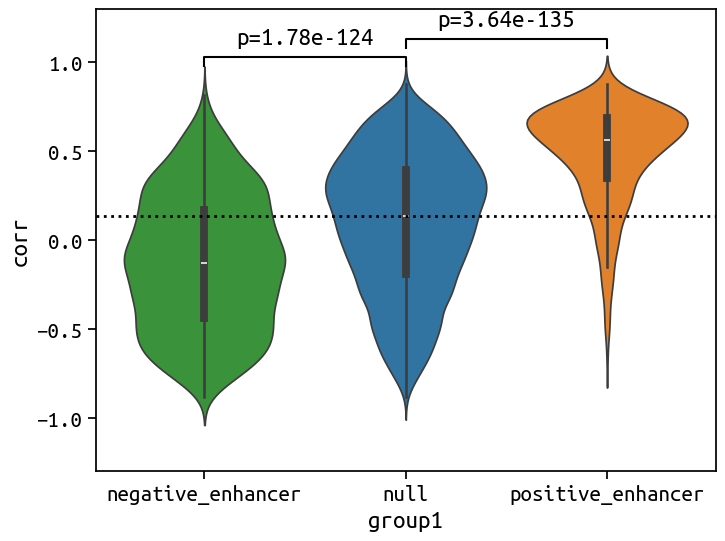

In [13]:
sns.set_context("notebook", font_scale=1.5)
print(plot_table["group1"].value_counts())
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(8)
fig.set_figheight(6)
sns.violinplot(
    plot_table, x="group1", y="corr", hue="group1", 
    order=["negative_enhancer", "null", "positive_enhancer"], ax=ax
)
null_median = np.median(group_null)
ax.axhline(null_median, color="black", linestyle="dotted", linewidth=2)
ax.set_ylim(-1.3, 1.3)
def add_bracket(x1, x2, y, pvalue, h, ax):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, color="black")
    ax.text((x1+x2)/2, y+2*h, f"p={pvalue:.2e}", ha="center", va="bottom")
bracket_base = np.max(plot_table["corr"])
add_bracket(0, 1, bracket_base+0.1, p_neg, 0.05, ax)
add_bracket(1, 2, bracket_base+0.2, p_pos, 0.05, ax)
fig.savefig(figure_dir / "enhancers_target_RNA_corr_scenic_only_bg.pdf", dpi=300, format="pdf")

In [14]:
rna_object = sc.read_h5ad("L2_3_IT_rna_matrix.h5ad")
rna_counts = rna_object.raw.to_adata()
rna_region_counts = dc.get_pseudobulk(
    adata=rna_counts,
    sample_col="Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    min_prop=0.0,
    min_smpls=0,
    remove_empty=True,
    mode="sum"
)
sc.pp.normalize_total(rna_region_counts, target_sum=1e6)
sc.pp.log1p(rna_region_counts, base=2)
region_align = ["A24", "A9", "FI", "MTG", "AnG", "M1C", "S1C", "A1C", "V1C"]

/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [15]:
ST_positive_genes_table = pd.read_csv(
    "../other_celltypes/corr_genes_7e-1_1e-2_expr_filtered/L2_3_IT_positive.tsv",
    header=None, sep="\t"
)
ST_positive_genes = ST_positive_genes_table[0].tolist()
ST_negative_genes_table = pd.read_csv(
    "../other_celltypes/corr_genes_7e-1_1e-2_expr_filtered/L2_3_IT_negative.tsv",
    header=None, sep="\t"
)
ST_negative_genes = ST_negative_genes_table[0].tolist()

In [16]:
ST_genes = ST_positive_genes + ST_negative_genes
plot_matrix = rna_region_counts[region_align, ST_genes].X.T.copy()
row_means = np.mean(plot_matrix, axis=1, keepdims=True)
row_stds = np.std(plot_matrix, axis=1, keepdims=True)
plot_matrix_z = (plot_matrix - row_means) / row_stds

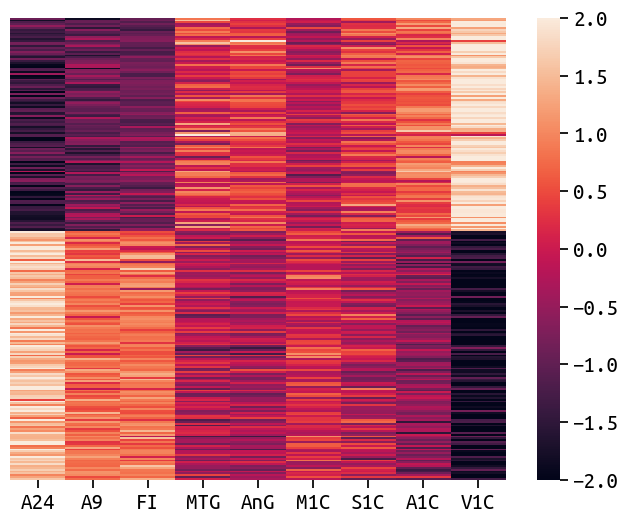

In [17]:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(8)
fig.set_figheight(6)
sns.heatmap(
    plot_matrix_z,
    xticklabels=region_align,
    yticklabels=[],
    vmin=-2,
    vmax=2,
    ax=ax
)
fig.savefig(figure_dir / "corr_genes_RNA.pdf", dpi=300, format="pdf")

In [18]:
receptor_pos_subunits = [
    "CHRM1", "CHRM2", "GABRA1", "GABRD", "GABRG3",
    "GRIK1", "GRIN1", "GRIN3B", "GRM4", "HTR1F"
]
receptor_neg_subunits = [
    "CHRM3", "GABRA2", "GABRA3", "GABRA5", "GABRB1",
    "GABRB3", "GRIK2", "GRIN2B", "GRM1", "GRM5",
    "GRM8", "HTR1E", "HTR4"
]

In [19]:
rsp_regulons = regulons_table[regulons_table["Gene"].isin(receptor_pos_subunits)].copy()
rsn_regulons = regulons_table[regulons_table["Gene"].isin(receptor_neg_subunits)].copy()

In [20]:
motif_database = pd.read_csv(
    "/tscc/projects/ps-epigen/users/biy022/MGH/data/metadata/homer2_motif_database.csv",
    header=0, sep=","
)
motif_database = motif_database.dropna()

homer_result_positive = pd.read_csv(
    "corr_regions_ST_5e-1_5e-2_expr_filtered/positive_homer_bg/knownResults.txt",
    header=0, sep="\t"
)
homer_result_positive = homer_result_positive[homer_result_positive["q-value (Benjamini)"] < 0.01]
homer_positive_tfs = motif_database[motif_database["motif_names"].isin(homer_result_positive["Motif Name"])]["tfs"].to_list()
homer_positive_tfs = set(homer_positive_tfs)

homer_result_negative = pd.read_csv(
    "corr_regions_ST_5e-1_5e-2_expr_filtered/negative_homer_bg/knownResults.txt",
    header=0, sep="\t"
)
homer_result_negative = homer_result_negative[homer_result_negative["q-value (Benjamini)"] < 0.01]
homer_negative_tfs = motif_database[motif_database["motif_names"].isin(homer_result_negative["Motif Name"])]["tfs"].to_list()
homer_negative_tfs = set(homer_negative_tfs)
homer_negative_tfs.add("RFX3")

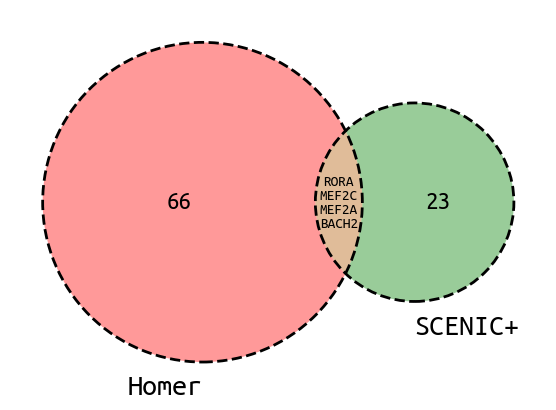

In [21]:
geneset_tfs = set(rsp_regulons["TF"].unique())
plt.figure(figsize=(8, 5))
venn = venn2([homer_positive_tfs, geneset_tfs], ("Homer", "SCENIC+"))
venn2_circles([homer_positive_tfs, geneset_tfs], linestyle="dashed", linewidth=2)
overlap = geneset_tfs & homer_positive_tfs
overlap_text = "\n".join(overlap)
overlap_label = venn.get_label_by_id('11')
overlap_label.set_text(overlap_text)
overlap_label.set_fontsize(11)
plt.savefig(figure_dir / "scenic_all_subunits_positive_homer_positive_venn.pdf", format="pdf", dpi=300)

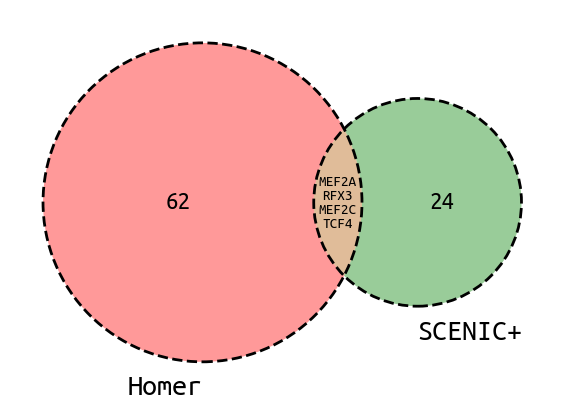

In [22]:
geneset_tfs = set(rsn_regulons["TF"].unique())
plt.figure(figsize=(8, 5))
venn = venn2([homer_negative_tfs, geneset_tfs], ("Homer", "SCENIC+"))
venn2_circles([homer_negative_tfs, geneset_tfs], linestyle="dashed", linewidth=2)
overlap = geneset_tfs & homer_negative_tfs
overlap_text = "\n".join(overlap)
overlap_label = venn.get_label_by_id('11')
overlap_label.set_text(overlap_text)
overlap_label.set_fontsize(11)
plt.savefig(figure_dir / "scenic_all_subunits_negative_homer_positive_venn.pdf", format="pdf", dpi=300)

In [23]:
intersected_genes = ["BACH2", "RORA", "MEF2A", "MEF2C", "RFX3", "TCF4",]
plot_matrix = rna_region_counts[region_align, intersected_genes].X.T.copy()
row_means = np.mean(plot_matrix, axis=1, keepdims=True)
row_stds = np.std(plot_matrix, axis=1, keepdims=True)
plot_matrix_z = (plot_matrix - row_means) / row_stds

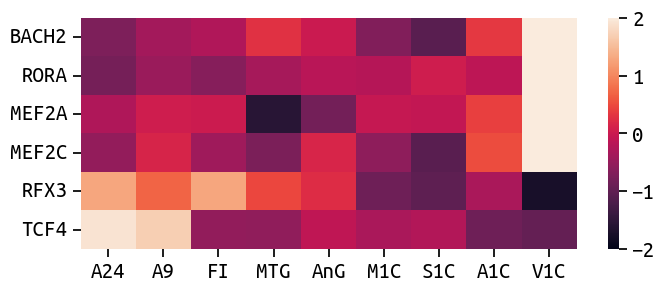

In [24]:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(8)
fig.set_figheight(3)
sns.heatmap(
    plot_matrix_z,
    xticklabels=region_align,
    yticklabels=intersected_genes,
    vmin=-2,
    vmax=2,
    ax=ax
)
fig.savefig(figure_dir / "venn_genes_RNA.pdf", dpi=300, format="pdf", bbox_inches="tight")

In [25]:
rsp_regulons.to_csv(
    "/tscc/projects/ps-epigen/users/biy022/biccn/analysis/final_files/L2_3_IT_positive_receptors_regulons.txt",
    sep="\t", header=True, index=False
)
rsn_regulons.to_csv(
    "/tscc/projects/ps-epigen/users/biy022/biccn/analysis/final_files/L2_3_IT_negative_receptors_regulons.txt",
    sep="\t", header=True, index=False
)

## Ridgeline plot

In [8]:
region_corr_table = pd.read_csv(
    "../other_celltypes/corr_regions_ST_5e-1_5e-2_expr_filtered/L2_3_IT_ST_table.tsv",
    sep="\t", header=0
)
region_corr_table["region"] = region_corr_table.apply(
    lambda x: ":".join(x["region"].split("-", 1)), axis=1)

In [9]:
receptor_pos_subunits = [
    "CHRM1", "CHRM2", "GABRA1", "GABRD", "GABRG3",
    "GRIK1", "GRIN1", "GRIN3B", "GRM4", "HTR1F"
]
receptor_neg_subunits = [
    "CHRM3", "GABRA2", "GABRA3", "GABRA5", "GABRB1",
    "GABRB3", "GRIK2", "GRIN2B", "GRM1", "GRM5",
    "GRM8", "HTR1E", "HTR4"
]

In [10]:
rsp_regulons = regulons_table[regulons_table["Gene"].isin(receptor_pos_subunits)].copy()
rsn_regulons = regulons_table[regulons_table["Gene"].isin(receptor_neg_subunits)].copy()

In [11]:
# rsp_tfs = list(set(rsp_regulons["TF"].unique()))
tf_frequency = rsp_regulons["TF"].value_counts()
sorted_freq = tf_frequency.sort_values(ascending=False)
cumsum_freq = sorted_freq.cumsum()
freq_threhold = 0.8 * len(rsp_regulons)
selected_tfs = cumsum_freq[cumsum_freq <= freq_threhold].index.to_list()

In [12]:
corr_lists = []
all_enhancer_corr = region_corr_table[["region", "corr"]].copy()
all_enhancer_corr["label"] = "null"
corr_lists.append(all_enhancer_corr)
for ctf in selected_tfs:
    ctf_enhancers = regulons_table[regulons_table["TF"] == ctf]["Region"].to_list()
    ctf_corr = region_corr_table.loc[region_corr_table["region"].isin(ctf_enhancers), ["region", "corr"]].copy()
    ctf_corr["label"] = ctf
    corr_lists.append(ctf_corr)

In [13]:
median_null = np.median(corr_lists[0]["corr"])
medians_all = [np.median(xx["corr"]) for xx in corr_lists]
sorted_indices = np.argsort(medians_all)
plot_corr_table = pd.concat([corr_lists[ii] for ii in sorted_indices], axis=0)

In [14]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
rank_sum_test_result = dict()
for factor_name in plot_corr_table["label"].unique():
    if factor_name == "null":
        continue
    values_null = plot_corr_table[plot_corr_table["label"] == "null"]["corr"]
    values_curr = plot_corr_table[plot_corr_table["label"] == factor_name]["corr"]
    stats_curr, p_curr = mannwhitneyu(values_curr, values_null)
    rank_sum_test_result[factor_name] = p_curr
keys = rank_sum_test_result.keys()
pvalues = np.array(list(rank_sum_test_result.values()))
adjusted_p = multipletests(pvalues, method="fdr_bh")[1]
rank_sum_test_result = {k: v for k, v in zip(keys, adjusted_p)}
for k in rank_sum_test_result:
    fdr_curr = rank_sum_test_result[k]
    print(f"Test result for {k} is: fdr, {fdr_curr:.2e}")
# rank_sum_test_result["MEF2C"] = 0.0357865
# rank_sum_test_result["ZNF207"] = 0.0756483

Test result for TCF4 is: fdr, 0.00e+00
Test result for RFX7 is: fdr, 3.73e-240
Test result for E2F3 is: fdr, 0.00e+00
Test result for KLF7 is: fdr, 8.60e-23
Test result for MEF2C is: fdr, 8.45e-82
Test result for MEF2A is: fdr, 2.76e-91
Test result for ZNF91 is: fdr, 4.08e-96
Test result for NRF1 is: fdr, 1.26e-199
Test result for RB1 is: fdr, 2.31e-59
Test result for NR3C1 is: fdr, 5.26e-29
Test result for ZNF704 is: fdr, 9.09e-04
Test result for KLF12 is: fdr, 6.09e-28
Test result for LIN28B is: fdr, 3.42e-17
Test result for BACH2 is: fdr, 1.12e-04
Test result for JDP2 is: fdr, 3.03e-55
Test result for RORA is: fdr, 1.12e-27


/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height

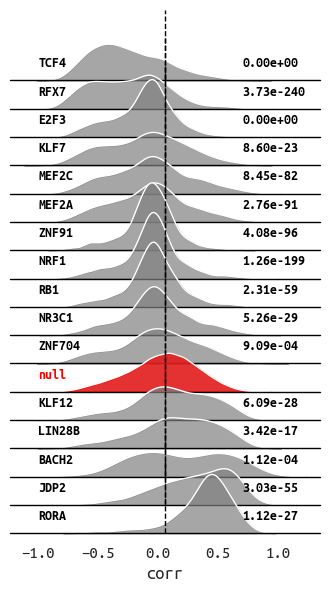

In [15]:
sns.set_theme(
    style="white", 
    rc={"axes.facecolor": (0, 0, 0, 0)}, 
    font="Ubuntu Mono",
    font_scale=1.1
)
pal = sns.cubehelix_palette(len(selected_tfs), rot=-.25, light=.7)
g = sns.FacetGrid(plot_corr_table, row="label", aspect=10, height=0.4, palette=pal)
g.map(sns.kdeplot, "corr", bw_adjust=1, clip_on=False, fill=True, alpha=0.7, linewidth=0.75, color="grey")
for la, ax in g.axes_dict.items():
    if la == "null":
        sns.kdeplot(
            data=plot_corr_table[plot_corr_table["label"] == "null"], x="corr", ax=ax,
            bw_adjust=1, clip_on=False, fill=True, alpha=0.7, linewidth=0.75, color="red",
        )
g.map(sns.kdeplot, "corr", bw_adjust=1, clip_on=False, color="w", lw=1)
g.refline(y=0, linewidth=1, linestyle="-", color="black", clip_on=False)
# g.map(plt.axhline, y=0, lw=2, clip_on=False)

labels = plot_corr_table["label"].unique()
for la, ax in g.axes_dict.items():
    if la == "null":
        ax.text(-1, 0.5, la, fontweight="bold", fontsize=10, color="red")
    else:
        ax.text(-1, 0.5, la, fontweight="bold", fontsize=10, color="black")
        ax.text(0.7, 0.5, "{:.2e}".format(rank_sum_test_result[la]), fontweight="bold", fontsize=10, color="black")
    ax.axvline(median_null, lw=1, color="black", linestyle="--")
    ax.set_ylabel("")
g.fig.subplots_adjust(hspace=-.6)
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

g.savefig(figure_dir / "scenic_positive_receptor_subunits_tfs_enhancers_corr_dist.pdf")

In [16]:
def compute_qq(observed_dist, null_dist):
    observed_sorted = np.sort(observed_dist)
    null_sorted = np.sort(null_dist)
    n_observed = len(observed_dist)
    quantiles = np.linspace(0, 1, n_observed)
    null_quantiles = np.quantile(null_sorted, quantiles)
    return observed_sorted, null_quantiles

In [17]:
quantile_datasets = list()
for factor_name in plot_corr_table["label"].unique():
    if factor_name == "null":
        continue
    ob_d = plot_corr_table[plot_corr_table["label"] == factor_name]["corr"].to_list()
    null_d = plot_corr_table[plot_corr_table["label"] == "null"]["corr"].to_list()
    ob_q, null_q = compute_qq(ob_d, null_d)
    curr_dataset = pd.DataFrame({
        "Null_quantiles": null_q,
        "Observed_quantiles": ob_q,
        "factor": factor_name
    })
    quantile_datasets.append(curr_dataset)
quantile_plot_dataset = pd.concat(quantile_datasets)

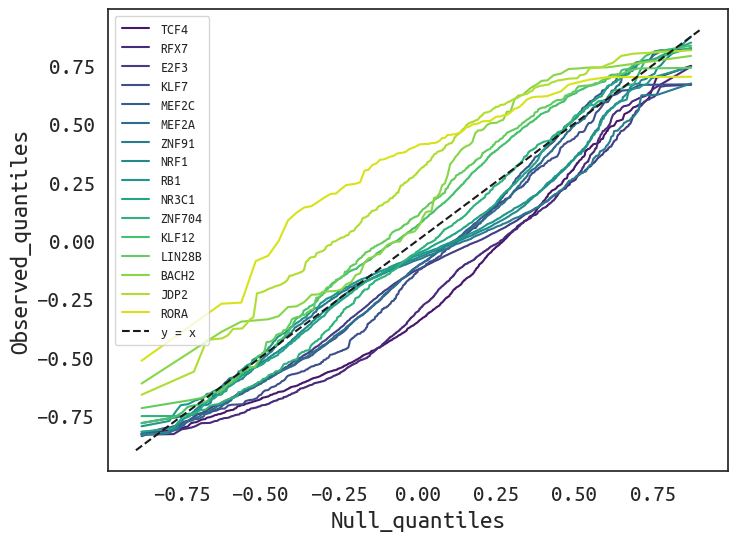

In [18]:
sns.set_context("notebook", font_scale=1.5)
fig, ax = plt.subplots(1, 1)
fig.set_figheight(6)
fig.set_figwidth(8)
sns.lineplot(
    quantile_plot_dataset,
    x="Null_quantiles",
    y="Observed_quantiles",
    hue="factor",
    palette="viridis"
)
plt.plot([-0.9, 0.9], [-0.9, 0.9], "k--", label="y = x")
plt.legend(
    bbox_to_anchor=(0, 1), 
    loc="upper left", 
    facecolor="white",
    borderpad=0.5,   
    prop={"size": 10}
)
plt.savefig(figure_dir / "scenic_positive_receptor_subunits_tfs_enhancers_qq.pdf")

In [19]:
## Keep only SCENIC+ enhancers
corr_lists = []
all_enhancer_corr = region_corr_table.loc[
    region_corr_table["region"].isin(regulons_table["Region"].to_list()), ["region", "corr"]].copy()
all_enhancer_corr["label"] = "null"
corr_lists.append(all_enhancer_corr)
for ctf in selected_tfs:
    ctf_enhancers = regulons_table[regulons_table["TF"] == ctf]["Region"].to_list()
    ctf_corr = region_corr_table.loc[region_corr_table["region"].isin(ctf_enhancers), ["region", "corr"]].copy()
    ctf_corr["label"] = ctf
    corr_lists.append(ctf_corr)

In [20]:
median_null = np.median(corr_lists[0]["corr"])
medians_all = [np.median(xx["corr"]) for xx in corr_lists]
sorted_indices = np.argsort(medians_all)
plot_corr_table = pd.concat([corr_lists[ii] for ii in sorted_indices], axis=0)

In [21]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
rank_sum_test_result = dict()
for factor_name in plot_corr_table["label"].unique():
    if factor_name == "null":
        continue
    values_null = plot_corr_table[plot_corr_table["label"] == "null"]["corr"]
    values_curr = plot_corr_table[plot_corr_table["label"] == factor_name]["corr"]
    stats_curr, p_curr = mannwhitneyu(values_curr, values_null)
    rank_sum_test_result[factor_name] = p_curr
keys = rank_sum_test_result.keys()
pvalues = np.array(list(rank_sum_test_result.values()))
adjusted_p = multipletests(pvalues, method="fdr_bh")[1]
rank_sum_test_result = {k: v for k, v in zip(keys, adjusted_p)}
for k in rank_sum_test_result:
    fdr_curr = rank_sum_test_result[k]
    print(f"Test result for {k} is: fdr, {fdr_curr:.2e}")
# rank_sum_test_result["MEF2C"] = 0.0357865
# rank_sum_test_result["ZNF207"] = 0.0756483

Test result for TCF4 is: fdr, 1.05e-99
Test result for RFX7 is: fdr, 1.66e-59
Test result for E2F3 is: fdr, 1.13e-04
Test result for KLF7 is: fdr, 8.85e-01
Test result for MEF2C is: fdr, 1.35e-08
Test result for MEF2A is: fdr, 1.14e-06
Test result for ZNF91 is: fdr, 1.15e-09
Test result for NRF1 is: fdr, 4.68e-34
Test result for RB1 is: fdr, 6.15e-26
Test result for NR3C1 is: fdr, 1.98e-51
Test result for ZNF704 is: fdr, 7.02e-16
Test result for KLF12 is: fdr, 1.68e-143
Test result for LIN28B is: fdr, 4.20e-58
Test result for BACH2 is: fdr, 4.39e-12
Test result for JDP2 is: fdr, 2.62e-91
Test result for RORA is: fdr, 3.20e-35


/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height

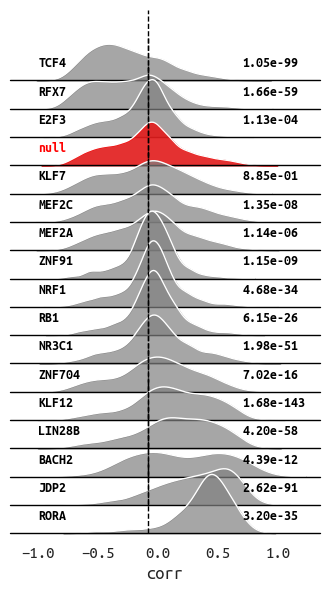

In [22]:
sns.set_theme(
    style="white", 
    rc={"axes.facecolor": (0, 0, 0, 0)}, 
    font="Ubuntu Mono",
    font_scale=1.1
)
pal = sns.cubehelix_palette(len(selected_tfs), rot=-.25, light=.7)
g = sns.FacetGrid(plot_corr_table, row="label", aspect=10, height=0.4, palette=pal)
g.map(sns.kdeplot, "corr", bw_adjust=1, clip_on=False, fill=True, alpha=0.7, linewidth=0.75, color="grey")
for la, ax in g.axes_dict.items():
    if la == "null":
        sns.kdeplot(
            data=plot_corr_table[plot_corr_table["label"] == "null"], x="corr", ax=ax,
            bw_adjust=1, clip_on=False, fill=True, alpha=0.7, linewidth=0.75, color="red",
        )
g.map(sns.kdeplot, "corr", bw_adjust=1, clip_on=False, color="w", lw=1)
g.refline(y=0, linewidth=1, linestyle="-", color="black", clip_on=False)
# g.map(plt.axhline, y=0, lw=2, clip_on=False)

labels = plot_corr_table["label"].unique()
for la, ax in g.axes_dict.items():
    if la == "null":
        ax.text(-1, 0.5, la, fontweight="bold", fontsize=10, color="red")
    else:
        ax.text(-1, 0.5, la, fontweight="bold", fontsize=10, color="black")
        ax.text(0.7, 0.5, "{:.2e}".format(rank_sum_test_result[la]), fontweight="bold", fontsize=10, color="black")
    ax.axvline(median_null, lw=1, color="black", linestyle="--")
    ax.set_ylabel("")
g.fig.subplots_adjust(hspace=-.6)
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

g.savefig(figure_dir / "scenic_positive_receptor_subunits_tfs_enhancers_corr_dist_scenic_only_bg.pdf")

In [23]:
# rsn_tfs = list(set(rsn_regulons["TF"].unique()))
tf_frequency = rsn_regulons["TF"].value_counts()
sorted_freq = tf_frequency.sort_values(ascending=False)
cumsum_freq = sorted_freq.cumsum()
freq_threhold = 0.8 * len(rsn_regulons)
selected_tfs = cumsum_freq[cumsum_freq <= freq_threhold].index.to_list()

In [24]:
corr_lists = []
all_enhancer_corr = region_corr_table[["region", "corr"]].copy()
all_enhancer_corr["label"] = "null"
corr_lists.append(all_enhancer_corr)
for ctf in selected_tfs:
    ctf_enhancers = regulons_table[regulons_table["TF"] == ctf]["Region"].to_list()
    ctf_corr = region_corr_table.loc[region_corr_table["region"].isin(ctf_enhancers), ["region", "corr"]].copy()
    ctf_corr["label"] = ctf
    corr_lists.append(ctf_corr)

In [25]:
median_null = np.median(corr_lists[0]["corr"])
medians_all = [np.median(xx["corr"]) for xx in corr_lists]
sorted_indices = np.argsort(medians_all)
plot_corr_table = pd.concat([corr_lists[ii] for ii in sorted_indices], axis=0)

In [26]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
rank_sum_test_result = dict()
for factor_name in plot_corr_table["label"].unique():
    if factor_name == "null":
        continue
    values_null = plot_corr_table[plot_corr_table["label"] == "null"]["corr"]
    values_curr = plot_corr_table[plot_corr_table["label"] == factor_name]["corr"]
    stats_curr, p_curr = mannwhitneyu(values_curr, values_null)
    rank_sum_test_result[factor_name] = p_curr
keys = rank_sum_test_result.keys()
pvalues = np.array(list(rank_sum_test_result.values()))
adjusted_p = multipletests(pvalues, method="fdr_bh")[1]
rank_sum_test_result = {k: v for k, v in zip(keys, adjusted_p)}
for k in rank_sum_test_result:
    fdr_curr = rank_sum_test_result[k]
    print(f"Test result for {k} is: fdr, {fdr_curr:.2e}")
# rank_sum_test_result["MEF2C"] = 0.0357865
# rank_sum_test_result["ZNF207"] = 0.0756483

Test result for RFX3 is: fdr, 0.00e+00
Test result for TCF4 is: fdr, 0.00e+00
Test result for SMAD3 is: fdr, 2.87e-191
Test result for RCOR1 is: fdr, 2.60e-65
Test result for POU2F1 is: fdr, 1.38e-241
Test result for E2F3 is: fdr, 0.00e+00
Test result for MEF2C is: fdr, 5.08e-82
Test result for MEF2A is: fdr, 1.63e-91
Test result for TFDP2 is: fdr, 1.03e-53
Test result for NRF1 is: fdr, 6.90e-200
Test result for RB1 is: fdr, 1.27e-59


/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height

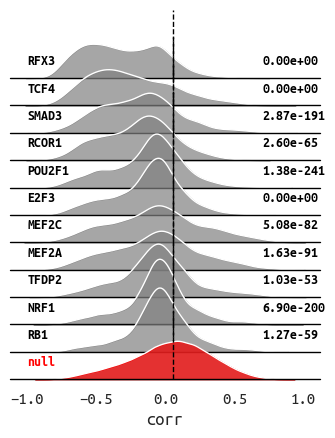

In [27]:
sns.set_theme(
    style="white", 
    rc={"axes.facecolor": (0, 0, 0, 0)}, 
    font="Ubuntu Mono",
    font_scale=1.1
)
pal = sns.cubehelix_palette(len(selected_tfs), rot=-.25, light=.7)
g = sns.FacetGrid(plot_corr_table, row="label", aspect=10, height=0.4, palette=pal)
g.map(sns.kdeplot, "corr", bw_adjust=1, clip_on=False, fill=True, alpha=0.7, linewidth=0.75, color="grey")
for la, ax in g.axes_dict.items():
    if la == "null":
        sns.kdeplot(
            data=plot_corr_table[plot_corr_table["label"] == "null"], x="corr", ax=ax,
            bw_adjust=1, clip_on=False, fill=True, alpha=0.7, linewidth=0.75, color="red",
        )
g.map(sns.kdeplot, "corr", bw_adjust=1, clip_on=False, color="w", lw=1)
g.refline(y=0, linewidth=1, linestyle="-", color="black", clip_on=False)
# g.map(plt.axhline, y=0, lw=2, clip_on=False)

labels = plot_corr_table["label"].unique()
for la, ax in g.axes_dict.items():
    if la == "null":
        ax.text(-1, 0.5, la, fontweight="bold", fontsize=10, color="red")
    else:
        ax.text(-1, 0.5, la, fontweight="bold", fontsize=10, color="black")
        ax.text(0.7, 0.5, "{:.2e}".format(rank_sum_test_result[la]), fontweight="bold", fontsize=10, color="black")
    ax.axvline(median_null, lw=1, color="black", linestyle="--")
    ax.set_ylabel("")
g.fig.subplots_adjust(hspace=-.6)
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

g.savefig(figure_dir / "scenic_negative_receptor_subunits_tfs_enhancers_corr_dist.pdf")

In [28]:
quantile_datasets = list()
for factor_name in plot_corr_table["label"].unique():
    if factor_name == "null":
        continue
    ob_d = plot_corr_table[plot_corr_table["label"] == factor_name]["corr"].to_list()
    null_d = plot_corr_table[plot_corr_table["label"] == "null"]["corr"].to_list()
    ob_q, null_q = compute_qq(ob_d, null_d)
    curr_dataset = pd.DataFrame({
        "Null_quantiles": null_q,
        "Observed_quantiles": ob_q,
        "factor": factor_name
    })
    quantile_datasets.append(curr_dataset)
quantile_plot_dataset = pd.concat(quantile_datasets)

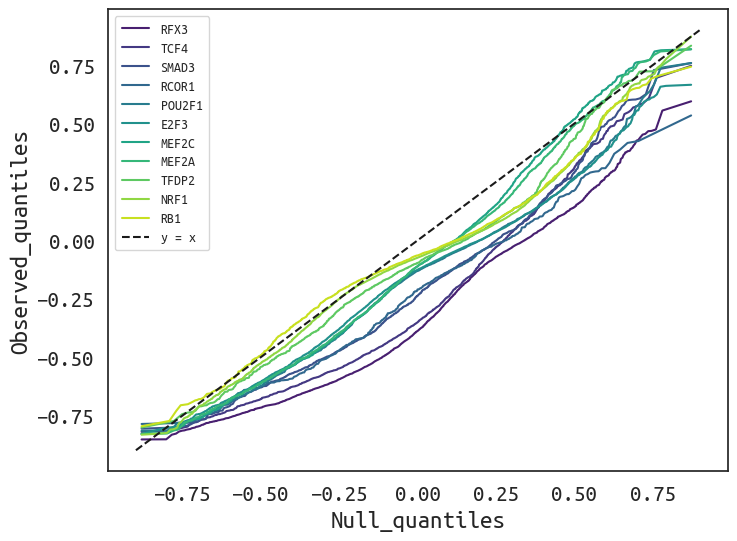

In [29]:
sns.set_context("notebook", font_scale=1.5)
fig, ax = plt.subplots(1, 1)
fig.set_figheight(6)
fig.set_figwidth(8)
sns.lineplot(
    quantile_plot_dataset,
    x="Null_quantiles",
    y="Observed_quantiles",
    hue="factor",
    palette="viridis"
)
plt.plot([-0.9, 0.9], [-0.9, 0.9], "k--", label="y = x")
plt.legend(
    bbox_to_anchor=(0, 1), 
    loc="upper left", 
    facecolor="white",
    borderpad=0.5,   
    prop={"size": 10}
)
plt.savefig(figure_dir / "scenic_negative_receptor_subunits_tfs_enhancers_qq.pdf")

In [30]:
## Keep only SCENIC+ enhancers
corr_lists = []
all_enhancer_corr = region_corr_table.loc[
    region_corr_table["region"].isin(regulons_table["Region"].to_list()), ["region", "corr"]].copy()
all_enhancer_corr["label"] = "null"
corr_lists.append(all_enhancer_corr)
for ctf in selected_tfs:
    ctf_enhancers = regulons_table[regulons_table["TF"] == ctf]["Region"].to_list()
    ctf_corr = region_corr_table.loc[region_corr_table["region"].isin(ctf_enhancers), ["region", "corr"]].copy()
    ctf_corr["label"] = ctf
    corr_lists.append(ctf_corr)

In [31]:
median_null = np.median(corr_lists[0]["corr"])
medians_all = [np.median(xx["corr"]) for xx in corr_lists]
sorted_indices = np.argsort(medians_all)
plot_corr_table = pd.concat([corr_lists[ii] for ii in sorted_indices], axis=0)

In [32]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
rank_sum_test_result = dict()
for factor_name in plot_corr_table["label"].unique():
    if factor_name == "null":
        continue
    values_null = plot_corr_table[plot_corr_table["label"] == "null"]["corr"]
    values_curr = plot_corr_table[plot_corr_table["label"] == factor_name]["corr"]
    stats_curr, p_curr = mannwhitneyu(values_curr, values_null)
    rank_sum_test_result[factor_name] = p_curr
keys = rank_sum_test_result.keys()
pvalues = np.array(list(rank_sum_test_result.values()))
adjusted_p = multipletests(pvalues, method="fdr_bh")[1]
rank_sum_test_result = {k: v for k, v in zip(keys, adjusted_p)}
for k in rank_sum_test_result:
    fdr_curr = rank_sum_test_result[k]
    print(f"Test result for {k} is: fdr, {fdr_curr:.2e}")
# rank_sum_test_result["MEF2C"] = 0.0357865
# rank_sum_test_result["ZNF207"] = 0.0756483

Test result for RFX3 is: fdr, 3.05e-290
Test result for TCF4 is: fdr, 7.20e-100
Test result for SMAD3 is: fdr, 1.85e-29
Test result for RCOR1 is: fdr, 2.07e-11
Test result for POU2F1 is: fdr, 1.88e-05
Test result for E2F3 is: fdr, 1.06e-04
Test result for MEF2C is: fdr, 1.72e-08
Test result for MEF2A is: fdr, 1.38e-06
Test result for TFDP2 is: fdr, 1.56e-05
Test result for NRF1 is: fdr, 8.59e-34
Test result for RB1 is: fdr, 7.61e-26


/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height

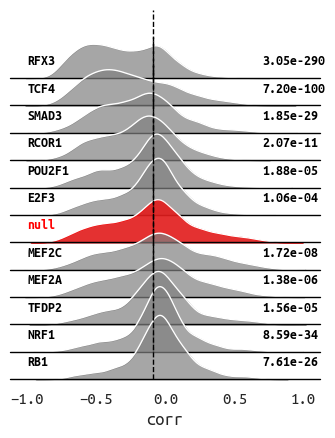

In [33]:
sns.set_theme(
    style="white", 
    rc={"axes.facecolor": (0, 0, 0, 0)}, 
    font="Ubuntu Mono",
    font_scale=1.1
)
pal = sns.cubehelix_palette(len(selected_tfs), rot=-.25, light=.7)
g = sns.FacetGrid(plot_corr_table, row="label", aspect=10, height=0.4, palette=pal)
g.map(sns.kdeplot, "corr", bw_adjust=1, clip_on=False, fill=True, alpha=0.7, linewidth=0.75, color="grey")
for la, ax in g.axes_dict.items():
    if la == "null":
        sns.kdeplot(
            data=plot_corr_table[plot_corr_table["label"] == "null"], x="corr", ax=ax,
            bw_adjust=1, clip_on=False, fill=True, alpha=0.7, linewidth=0.75, color="red",
        )
g.map(sns.kdeplot, "corr", bw_adjust=1, clip_on=False, color="w", lw=1)
g.refline(y=0, linewidth=1, linestyle="-", color="black", clip_on=False)
# g.map(plt.axhline, y=0, lw=2, clip_on=False)

labels = plot_corr_table["label"].unique()
for la, ax in g.axes_dict.items():
    if la == "null":
        ax.text(-1, 0.5, la, fontweight="bold", fontsize=10, color="red")
    else:
        ax.text(-1, 0.5, la, fontweight="bold", fontsize=10, color="black")
        ax.text(0.7, 0.5, "{:.2e}".format(rank_sum_test_result[la]), fontweight="bold", fontsize=10, color="black")
    ax.axvline(median_null, lw=1, color="black", linestyle="--")
    ax.set_ylabel("")
g.fig.subplots_adjust(hspace=-.6)
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

g.savefig(figure_dir / "scenic_negative_receptor_subunits_tfs_enhancers_corr_dist_scenic_only_bg.pdf")

In [34]:
rna_object = sc.read_h5ad("L2_3_IT_rna_matrix.h5ad")
rna_counts = rna_object.raw.to_adata()
rna_region_counts = dc.get_pseudobulk(
    adata=rna_counts,
    sample_col="Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    min_prop=0.0,
    min_smpls=0,
    remove_empty=True,
    mode="sum"
)
sc.pp.normalize_total(rna_region_counts, target_sum=1e6)
sc.pp.log1p(rna_region_counts, base=2)
region_align = ["A24", "A9", "FI", "MTG", "AnG", "M1C", "S1C", "A1C", "V1C"]

/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [35]:
intersected_genes = ["BACH2", "RORA", "JDP2", "RFX3", "TCF4"]
plot_matrix = rna_region_counts[region_align, intersected_genes].X.T.copy()
row_means = np.mean(plot_matrix, axis=1, keepdims=True)
row_stds = np.std(plot_matrix, axis=1, keepdims=True)
plot_matrix_z = (plot_matrix - row_means) / row_stds

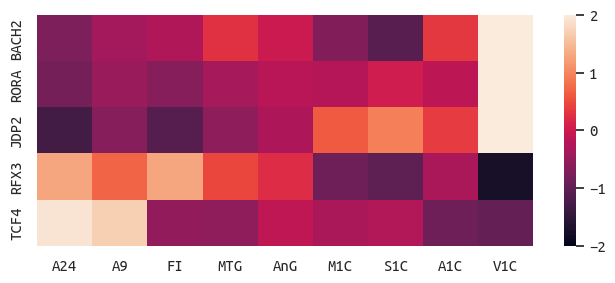

In [36]:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(8)
fig.set_figheight(3)
sns.heatmap(
    plot_matrix_z,
    xticklabels=region_align,
    yticklabels=intersected_genes,
    vmin=-2,
    vmax=2,
    ax=ax
)
fig.savefig(figure_dir / "dist_selected_genes_RNA.pdf", dpi=300, format="pdf", bbox_inches="tight")

In [37]:
regulons_table.to_csv(
    "/tscc/projects/ps-epigen/users/biy022/biccn/analysis/final_files/L2_3_IT_SCENIC_++_regulons.tsv",
    sep="\t", header=True, index=False
)

## Plot all TFs

In [38]:
region_corr_table = pd.read_csv(
    "../other_celltypes/corr_regions_ST_5e-1_5e-2_expr_filtered/L2_3_IT_ST_table.tsv",
    sep="\t", header=0
)
region_corr_table["region"] = region_corr_table.apply(
    lambda x: ":".join(x["region"].split("-", 1)), axis=1)

In [39]:
corr_lists = []
all_enhancer_corr = region_corr_table.loc[
    region_corr_table["region"].isin(regulons_table["Region"].to_list()), ["region", "corr"]].copy()
all_enhancer_corr["label"] = "null"
corr_lists.append(all_enhancer_corr)
for ctf in regulons_table["TF"].unique():
    ctf_enhancers = regulons_table[regulons_table["TF"] == ctf]["Region"].to_list()
    ctf_corr = region_corr_table.loc[region_corr_table["region"].isin(ctf_enhancers), ["region", "corr"]].copy()
    ctf_corr["label"] = ctf
    corr_lists.append(ctf_corr)

In [40]:
median_null = np.median(corr_lists[0]["corr"])
medians_all = [np.median(xx["corr"]) for xx in corr_lists]
sorted_indices = np.argsort(medians_all)
plot_corr_table = pd.concat([corr_lists[ii] for ii in sorted_indices], axis=0)

In [41]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
rank_sum_test_result = dict()
for factor_name in plot_corr_table["label"].unique():
    if factor_name == "null":
        continue
    values_null = plot_corr_table[plot_corr_table["label"] == "null"]["corr"]
    values_curr = plot_corr_table[plot_corr_table["label"] == factor_name]["corr"]
    stats_curr, p_curr = mannwhitneyu(values_curr, values_null)
    rank_sum_test_result[factor_name] = p_curr
keys = rank_sum_test_result.keys()
pvalues = np.array(list(rank_sum_test_result.values()))
adjusted_p = multipletests(pvalues, method="fdr_bh")[1]
rank_sum_test_result = {k: v for k, v in zip(keys, adjusted_p)}

/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height

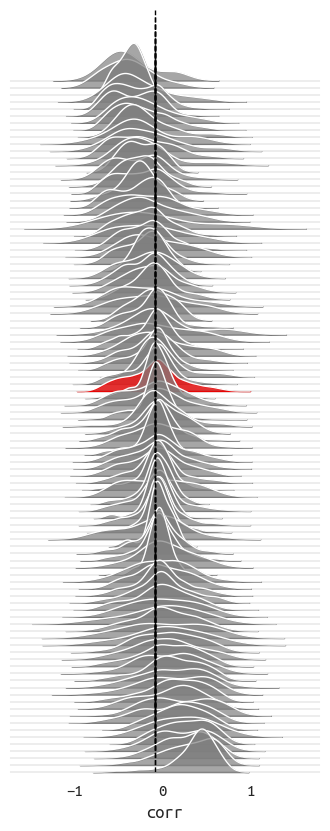

In [42]:
sns.set_theme(
    style="white", 
    rc={"axes.facecolor": (0, 0, 0, 0)}, 
    font="Ubuntu Mono",
    font_scale=1.1
)
pal = sns.cubehelix_palette(len(regulons_table["TF"].unique()), rot=-.25, light=.7)
g = sns.FacetGrid(plot_corr_table, row="label", aspect=40, height=0.1, palette=pal)
g.map(sns.kdeplot, "corr", bw_adjust=1, clip_on=False, fill=True, alpha=0.7, linewidth=0.75, color="grey")
for la, ax in g.axes_dict.items():
    if la == "null":
        sns.kdeplot(
            data=plot_corr_table[plot_corr_table["label"] == "null"], x="corr", ax=ax,
            bw_adjust=1, clip_on=False, fill=True, alpha=0.7, linewidth=0.75, color="red",
        )
g.map(sns.kdeplot, "corr", bw_adjust=1, clip_on=False, color="w", lw=1)
g.refline(y=0, linewidth=0.1, linestyle="-", color="black", clip_on=False)
# g.map(plt.axhline, y=0, lw=2, clip_on=False)

labels = plot_corr_table["label"].unique()
for la, ax in g.axes_dict.items():
    # if la == "null":
    #     ax.text(-1, 0.5, la, fontweight="bold", fontsize=10, color="red")
    # else:
        # ax.text(-1, 0.5, la, fontweight="bold", fontsize=10, color="black")
        # ax.text(0.7, 0.5, "{:.2e}".format(rank_sum_test_result[la]), fontweight="bold", fontsize=10, color="black")
    ax.axvline(median_null, lw=1, color="black", linestyle="--")
    ax.set_ylabel("")
g.fig.subplots_adjust(hspace=-.9)
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

g.savefig(figure_dir / "L2_3_IT_scenic_all_tfs_enhancers_corr_dist.pdf")

## RFX3 enhancers

In [9]:
dbsnp_chr_name_map = {
    "chr1": "NC_000001.11",
    "chr2": "NC_000002.12",
    "chr3": "NC_000003.12",
    "chr4": "NC_000004.12",
    "chr5": "NC_000005.10",
    "chr6": "NC_000006.12",
    "chr7": "NC_000007.14",
    "chr8": "NC_000008.11",
    "chr9": "NC_000009.12",
    "chr10": "NC_000010.11",
    "chr11": "NC_000011.10",
    "chr12": "NC_000012.12",
    "chr13": "NC_000013.11",
    "chr14": "NC_000014.9",
    "chr15": "NC_000015.10",
    "chr16": "NC_000016.10",
    "chr17": "NC_000017.11",
    "chr18": "NC_000018.10",
    "chr19": "NC_000019.10",
    "chr20": "NC_000020.11",
    "chr21": "NC_000021.9",
    "chr22": "NC_000022.11",
    "chrX": "NC_000023.11",
    "chrY": "NC_000024.10"
}

In [10]:
tf_df = regulons_table[regulons_table["TF"] == "RFX3"].copy()

In [11]:
tf_df[["chr", "range"]] = tf_df["Region"].str.split(":", expand=True)
tf_df[["start", "end"]] = tf_df["range"].str.split("-", expand=True)
del tf_df["range"]
tf_df["chr"] = tf_df["chr"].map(dbsnp_chr_name_map)

In [14]:
tf_df[["chr", "start", "end"]].to_csv(
    "tf_regulons/rfx3_enhancers.bed", 
    sep="\t", 
    header=False,
    index=False
)